In [0]:
import pandas as pd
import numpy as np
X1 = pd.read_csv('gmm_labels.csv') 
X2 = pd.read_csv('db_labels.csv') 
X3 = pd.read_csv('aggl_labels.csv') 
!pip install munkres

In [0]:
X1.head()

,Unnamed: 0,0
0,0,0
1,1,3
2,2,2
3,3,2
4,4,2


In [0]:
X1.columns = ['ind', 'label']
X2.columns = ['ind', 'label']
X3.columns = ['ind', 'label']

In [0]:
labels1=X1['label'].to_numpy()
labels2=X2['label'].to_numpy()
labels3=X3['label'].to_numpy()

In [0]:
print(set(labels1))
print(set(labels2))
print(set(labels3))

{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4, -1}
{0, 1, 2, 3, 4}


In [0]:
import matplotlib.pyplot as plt 
from pandas import DataFrame 
from sklearn import datasets 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA 

In [0]:
X = pd.read_csv('reduced_df.csv') 

  
# Dropping the CUST_ID column from the data 
  
# Handling the missing values 
X.fillna(method ='ffill', inplace = True) 
  
print(X.head()) 

   Unnamed: 0  BALANCE_FREQUENCY  ONEOFF_PURCHASES  ...  installment  none  one_off
0           0           0.597837          0.000000  ...            1     0        0
1           1           0.646627          0.000000  ...            0     1        0
2           2           0.693147          6.651791  ...            0     0        1
3           3           0.492477          7.313220  ...            0     0        1
4           4           0.693147          2.833213  ...            0     0        1

[5 rows x 18 columns]


In [0]:
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) 
  
# Normalizing the data so that  
# the data approximately follows a Gaussian distribution 
X_normalized = normalize(X_scaled) 
  
# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_normalized) 

In [0]:
pca = PCA(n_components = 5) 
X_principal = pca.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2','P3','P4','P5'] 
print(X_principal.head()) 

         P1        P2        P3        P4        P5
0  0.056811  0.615722  0.279367 -0.009008  0.259617
1  0.873206 -0.034449 -0.184796  0.268683  0.135682
2 -0.192561 -0.508472  0.506714 -0.379634  0.131159
3  0.314447 -0.366759  0.527698 -0.265992  0.032511
4  0.418327 -0.159671  0.557747 -0.297372  0.373932


In [0]:
from munkres import Munkres
import sys
import copy

def replaced(array, u1, u2, cor):
	replaced = copy.deepcopy(array)
	# cor is the corresponding list
	for row, col in cor:
		# u1[row] and u2[row] is corresponded
		for idx in range(len(array)):
			# if the element of array is equal to u2[col]
			if array[idx] == u2[col]:
				# the element is corresponding to u1[row]
				# so isolated list replaced is replaced by u1[row]
				replaced[idx] = u1[row]
	return replaced

def benefit_to_cost(matrix):
	cost_matrix = []
	for row in matrix:
		cost_row = []
		for col in row:
			cost_row = cost_row + [(sys.maxsize - col)]
		cost_matrix = cost_matrix + [cost_row]
	return cost_matrix

def relabel(array1, array2):
	# this function returns relabeled array2
	
	if len(array1) == len(array2):
		# set1 is the unique set of array1
		set1 = set(array1)
		# u1 is the unique list of array1
		u1 = list(set1)
		
		# set2 is the unique set of array2
		set2 = set(array2)
		# u2 is the unique list of array2
		u2 = list(set2)
		
		# matirx is the Corresponding matrix between u1 and u2
		matrix = [[0 for i in range(len(u2))] for j in range(len(u1))]
		
		for i in range(len(array1)):
			# item_1 is the index of array1's element in u1
			item_1 = u1.index(array1[i])
			# item_2 is the index of array2's element in u2
			item_2 = u2.index(array2[i])
			
			# this situation means 1 correspondence between item_1 and item_2 is observed
			# so corresponding location in corresponding matrix is incremented
			matrix[item_1][item_2] = matrix[item_1][item_2] + 1
			
		cost_matrix = benefit_to_cost(matrix)
		
		# Munkers library solve the cost minimization problem
		# but I would like to solve benefit maxmization problem
		# so convert benefit matrix into cost matrix
		
		# create mukres object
		m = Munkres()
		# get the most corresponded correspondance
		indexes = m.compute(cost_matrix)
		
		# I use array2 as Integer array so, convert it in case
		array2 = list(map(int, array2))
		
		# call replaced function to replace array2 according to object indexes
		replaced_matrix = replaced(array2, u1, u2, indexes)
		
		return replaced_matrix

def relabel_cluster(clusters):
	""" use first object in list object clusters as criteria"""
	criteria = clusters[0]
	
	# M is the number of review in each clustering
	M = len(criteria)
	
	# N is the number of clustering
	N = len(clusters)
	
	for idx in range(1, N):
		# if wrong size of clustering appears, stop the process
		if len(clusters[idx]) != M:
			print("Clusters " + str(idx) + " is out of size")
			return -1
		clusters[idx] = relabel(criteria, clusters[idx])
	return clusters

def transpose(array):
	# Transpose list
	return list(map(list, zip(*array)))

def voting(clusters):
	# Transpose Clusters
	clusters = transpose(clusters)
	voted = []
	for row in clusters:
		# Unique Set of item in the row
		u = list(set(row))
		# Counter corresponding to object u
		counter = [0 for i in u]
		
		# fill object counter by counting the object u in object row
		for idx in range(len(u)):
			counter[idx] = row.count(u[idx])
		
		# find the index of the most appeared object in the row
		max_idx = counter.index(max(counter))
		
		# choose the most appeared object
		voted = voted + [u[max_idx]]
	
	# return the result of majority vote
	return voted

if __name__ == '__main__':
	clusters = [labels1, labels3]
	print("Input:")
	for cluster in clusters:
		print(cluster)
	print("========")
	
	# relabelling phase
	relabeled_clusters = relabel_cluster(clusters)
	print("relabeled clusters:")
	for cluster in relabeled_clusters:
		print(cluster)
	print("========")
	
	# voting phase
	print("Output:")
	labels=voting(relabeled_clusters)
	# print replace_by_cor([0, 1, 2], [[0, 2], [1, 1], [2, 0]])


Input:
[0 3 2 ... 0 3 2]
[1 2 0 ... 1 2 0]
relabeled clusters:
[0 3 2 ... 0 3 2]
[0, 3, 2, 2, 2, 0, 1, 0, 1, 2, 0, 2, 1, 1, 3, 0, 3, 0, 1, 0, 0, 4, 0, 4, 3, 0, 2, 0, 4, 0, 4, 4, 2, 2, 0, 3, 3, 4, 2, 2, 3, 4, 2, 3, 1, 4, 0, 3, 1, 2, 4, 1, 3, 2, 0, 2, 2, 1, 3, 0, 2, 2, 3, 2, 0, 1, 3, 3, 1, 2, 0, 4, 3, 1, 1, 1, 2, 0, 3, 2, 1, 3, 1, 0, 4, 2, 4, 4, 2, 3, 4, 4, 2, 2, 2, 3, 2, 3, 0, 3, 2, 0, 1, 0, 3, 2, 0, 3, 4, 4, 1, 3, 4, 3, 1, 1, 0, 3, 0, 3, 4, 2, 0, 3, 3, 2, 3, 1, 2, 3, 2, 1, 0, 2, 0, 1, 1, 4, 1, 2, 1, 3, 3, 1, 1, 2, 0, 2, 1, 4, 0, 1, 0, 4, 1, 0, 4, 3, 1, 2, 3, 3, 1, 1, 0, 3, 0, 4, 0, 1, 3, 4, 0, 3, 4, 3, 2, 3, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 2, 2, 2, 2, 2, 0, 2, 1, 1, 1, 2, 0, 2, 4, 0, 4, 1, 0, 2, 4, 4, 1, 4, 1, 3, 2, 0, 0, 4, 1, 4, 4, 1, 1, 2, 1, 2, 2, 1, 1, 3, 1, 1, 0, 2, 2, 4, 2, 0, 4, 0, 1, 2, 1, 1, 2, 1, 0, 1, 0, 0, 1, 2, 0, 0, 2, 3, 0, 2, 4, 0, 3, 2, 4, 4, 4, 1, 1, 1, 2, 2, 4, 4, 2, 1, 1, 4, 2, 2, 2, 0, 4, 1, 0, 1, 1, 3, 3, 3, 4, 2, 3, 1, 4, 2, 3, 0, 1, 2, 3, 2, 2, 2, 1, 3, 1, 3, 1, 

In [0]:
X_principal.head

<bound method NDFrame.head of             P1        P2        P3        P4        P5  Cluster
0     0.056811  0.615722  0.279367 -0.009008  0.259617        0
1     0.873206 -0.034449 -0.184796  0.268683  0.135682        3
2    -0.192561 -0.508472  0.506714 -0.379634  0.131159        2
3     0.314447 -0.366759  0.527698 -0.265992  0.032511        2
4     0.418327 -0.159671  0.557747 -0.297372  0.373932        2
...        ...       ...       ...       ...       ...      ...
8945 -0.448445  0.725984  0.020431 -0.050491 -0.242283        0
8946 -0.408534  0.741187 -0.018148 -0.214093 -0.110101        0
8947 -0.316981  0.806950  0.078341 -0.151442 -0.128083        0
8948  0.758393  0.268883  0.122112  0.310031  0.061995        3
8949  0.034079 -0.508083  0.294610 -0.355161 -0.505743        2

[8950 rows x 6 columns]>

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


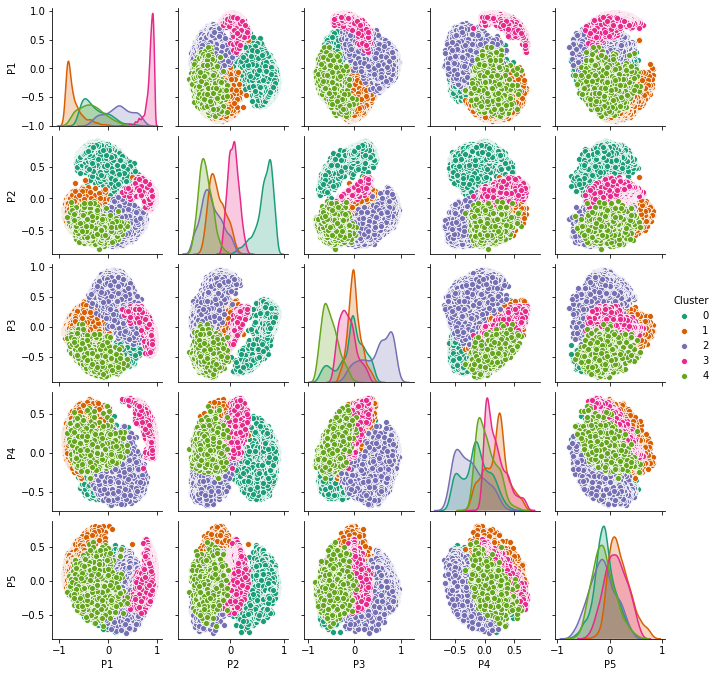

In [0]:
import seaborn as sns
df_pair_plot=pd.DataFrame(X_principal)
df_pair_plot['Cluster']=labels
df_pair_plot.head()
sns.pairplot(df_pair_plot,hue='Cluster', palette= 'Dark2', diag_kind='kde',size=1.85)

In [0]:
from sklearn import metrics
from sklearn.metrics import calinski_harabaz_score,silhouette_score
best_sil_score=silhouette_score(X_principal,labels)
best_cal_score=calinski_harabaz_score(X_principal,labels)
print('Silhouette Score is {}'.format(best_sil_score))
print('Calinski_harabaz Score is {}'.format(best_cal_score))

Silhouette Score is 0.6288263797727368
Calinski_harabaz Score is 24487.80371883145


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


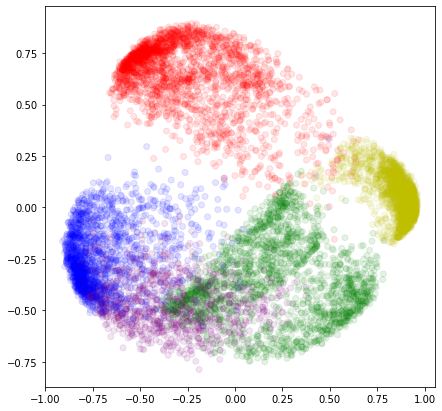

In [0]:
color_map={0:'r',1:'b',2:'g',3:'y',4:'purple'}
label_color=[color_map[l] for l in labels]
plt.figure(figsize=(7,7))
plt.scatter(x='P1',y='P2',c=label_color,cmap='Spectral',alpha=0.1,data=X_principal)

In [0]:
credit=pd.read_csv('credit.csv')
col=['BALANCE','PURCHASES','CASH_ADVANCE','TENURE','PAYMENTS','MINIMUM_PAYMENTS','PRC_FULL_PAYMENT','CREDIT_LIMIT']
col_kpi=['PURCHASES_TRX','Monthly_avg_purchase','Monthly_cash_advance','limit_usage','CASH_ADVANCE_TRX',
         'payment_minpay','both_oneoff_installment','installment','one_off','none','CREDIT_LIMIT']
cre_original=pd.concat([credit,pd.get_dummies(credit['purchase_type'])],axis=1)
cr_log=credit.drop(['CUST_ID','purchase_type'],axis=1).applymap(lambda x: np.log(x+1))

cr_pre=cr_log[[x for x in cr_log.columns if x not in col ]] 
cr_pre.describe()
cluster_df_4=pd.concat([cre_original[col_kpi],pd.Series(labels,name='Cluster_4')],axis=1)

In [0]:
print(set(cluster_df_4['Cluster_4']))

{0, 1, 2, 3, 4}


In [0]:
cluster_4=cluster_df_4.groupby('Cluster_4')\
.apply(lambda x: x[col_kpi].mean()).T
cluster_4

Cluster_4,0,1,2,3,4
PURCHASES_TRX,11.890363,33.923937,7.109925,0.001471,31.179331
Monthly_avg_purchase,46.932814,205.332620,69.688958,0.000000,169.578463
Monthly_cash_advance,38.579162,0.770183,78.995966,182.888800,189.220973
limit_usage,0.278472,0.253659,0.381074,0.566764,0.534245
CASH_ADVANCE_TRX,1.267462,0.026846,2.932231,6.305542,7.912867
payment_minpay,14.513852,8.525100,5.571082,8.696784,4.897016
both_oneoff_installment,0.000000,0.999441,0.000000,0.000000,1.000000
installment,0.999116,0.000000,0.000000,0.000000,0.000000
one_off,0.000000,0.000000,1.000000,0.000000,0.000000
none,0.000884,0.000559,0.000000,1.000000,0.000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


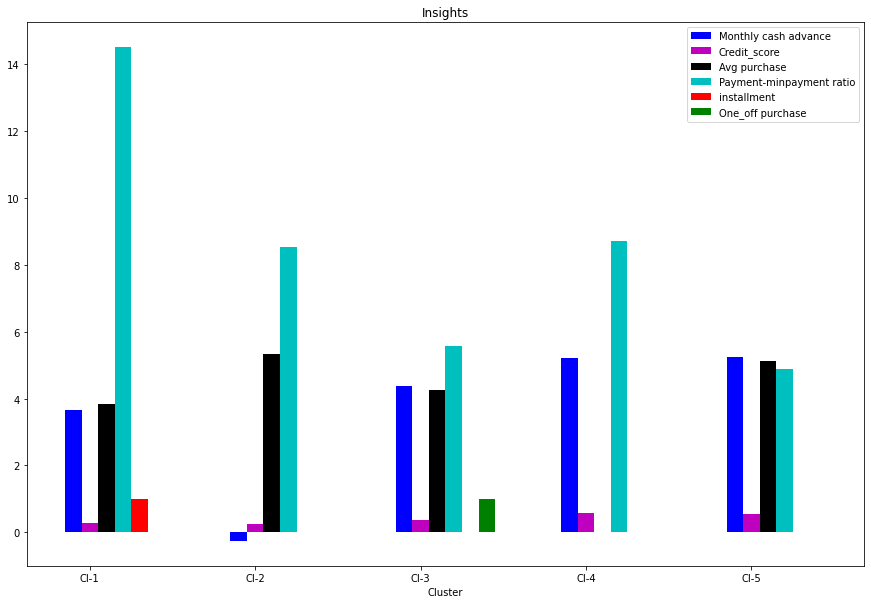

In [0]:
fig,ax=plt.subplots(figsize=(15,10))
index=np.arange(len(cluster_4.columns))

cash_advance=np.log(cluster_4.loc['Monthly_cash_advance',:].values)
credit_score=(cluster_4.loc['limit_usage',:].values)
purchase= np.log(cluster_4.loc['Monthly_avg_purchase',:].values)
payment=cluster_4.loc['payment_minpay',:].values
installment=cluster_4.loc['installment',:].values
one_off=cluster_4.loc['one_off',:].values


bar_width=.10
b1=plt.bar(index,cash_advance,color='b',label='Monthly cash advance',width=bar_width)
b2=plt.bar(index+bar_width,credit_score,color='m',label='Credit_score',width=bar_width)
b3=plt.bar(index+2*bar_width,purchase,color='k',label='Avg purchase',width=bar_width)
b4=plt.bar(index+3*bar_width,payment,color='c',label='Payment-minpayment ratio',width=bar_width)
b5=plt.bar(index+4*bar_width,installment,color='r',label='installment',width=bar_width)
b6=plt.bar(index+5*bar_width,one_off,color='g',label='One_off purchase',width=bar_width)

plt.xlabel("Cluster")
plt.title("Insights")
plt.xticks(index + bar_width, ('Cl-1', 'Cl-2', 'Cl-3', 'Cl-4', 'Cl-5'))
plt.legend()

In [0]:
# Percentage of each cluster in the total customer base
s=cluster_df_4.groupby('Cluster_4').apply(lambda x: x['Cluster_4'].value_counts())
print (s),'\n'

per=pd.Series((s.values.astype('float')/ cluster_df_4.shape[0])*100,name='Percentage')
print ("Cluster -4 "),'\n'
print (pd.concat([pd.Series(s.values,name='Size'),per],axis=1))

Cluster_4   
0          0    2262
1          1    1788
2          2    1874
3          3    2039
4          4     987
Name: Cluster_4, dtype: int64
Cluster -4 
   Size  Percentage
0  2262   25.273743
1  1788   19.977654
2  1874   20.938547
3  2039   22.782123
4   987   11.027933
